# Embedding visualisation

This notebook will visualise the knowledge graph embeddings using the UMAP algorithm.

In [1]:
import pandas as pd
import numpy as np 
import pickle
import tensorflow as tf
import torch
from umap import UMAP
from itertools import product
from collections import OrderedDict

First we'll import the trained embeddings from the pickle files in the `data/` directory. We have five embedding models: TransE, TransR, ConvE, ComplEx, and Hierarchical TransR.

In [2]:
# import models, get embeddings

transE_model = pickle.load(open('data/models/transE_model.p', 'rb'))
transE_embeddings = transE_model['model'].entity_embeddings.cpu()
transR_model = pickle.load(open('data/models/transR_model.p', 'rb'))
transR_embeddings = transR_model['model'].entity_embeddings.cpu()
convE_model = pickle.load(open('data/models/convE_model.p', 'rb'))
convE_embeddings = convE_model['model'].entity_embeddings.cpu()
complEx_model = pickle.load(open('data/models/complEx_model.p', 'rb'))
complEx_embeddings = complEx_model['model'].entity_embeddings.cpu()
custom_model = pickle.load(open('data/models/custom_model.p', 'rb'))
custom_embeddings = custom_model['ent_embeddings']

Then we'll import the train/test sets for the PyKeen embedding models and the custom embedding model Hierarchical TransR. 

In [3]:
# import train/test

pykeen_train = pd.read_csv('data/models/pykeen_train.tsv', sep = '\t')
pykeen_test = pd.read_csv('data/models/pykeen_test.tsv', sep = '\t')
custom_train = pd.read_csv('data/models/custom_train.tsv', sep = '\t')
custom_test = pd.read_csv('data/models/custom_test.tsv', sep = '\t')

We'll make a dictionary mapping entity indices in the train/test sets to graph node IDs so we can extract information about entities from the graph dictionary.

In [4]:
# make dictionaries mapping entity index to entity id 

custom_all_entities = custom_train['head'].append(custom_train['tail'])
custom_all_entity_ids = custom_train['head_id'].append(custom_train['tail_id'])
custom_entity_idx2id = {ent_idx: ent_id for ent_idx, ent_id in zip(custom_all_entities, custom_all_entity_ids)}

pykeen_all_entities = pykeen_train['head'].append(pykeen_train['tail'])
pykeen_all_entity_ids = pykeen_train['head_id'].append(pykeen_train['tail_id'])
pykeen_entity_idx2id = {ent_idx: ent_id for ent_idx, ent_id in zip(pykeen_all_entities, pykeen_all_entity_ids)}

We'll get the type of each entity with a trained embedding (either gene or GO term).

In [5]:
# extract entities with embeddings in pykeen and custom models, and get entity types

pykeen_embedded_entities = pd.unique(pykeen_all_entities)
pykeen_entity_types = ['Gene' if custom_model['entities'][pykeen_entity_idx2id[ent]]['labels'] == ['Gene'] else 'Gene Ontology term' 
                       for ent in pykeen_embedded_entities]
pykeen_entity_tensor = torch.tensor(pykeen_embedded_entities, dtype = torch.long)

custom_embedded_entities = pd.unique(custom_all_entities)
custom_entity_types = ['Gene' if custom_model['entities'][custom_entity_idx2id[ent]]['labels'] == ['Gene'] else 'Gene Ontology term' 
                       for ent in custom_embedded_entities]

In [6]:
# gather all entity embeddings into a dictionary

all_embeddings = OrderedDict({'TransE': transE_embeddings(pykeen_entity_tensor).detach().numpy(), 
                              'TransR': transR_embeddings(pykeen_entity_tensor).detach().numpy(),
                              'ConvE': convE_embeddings(pykeen_entity_tensor).detach().numpy(), 
                              'ComplEx': complEx_embeddings(pykeen_entity_tensor).detach().numpy(),
                              'Hierarchical TransR': tf.gather(custom_embeddings, custom_embedded_entities).numpy()})

Now we can run a UMAP on all embedded entities.

In [7]:
# run umaps

embedding_umaps = OrderedDict({model: UMAP(random_state = 123).fit_transform(all_embeddings[model])
                               for model in all_embeddings})

And plot the resulting 2D projections, colouring entities based on whether they are genes or GO terms.

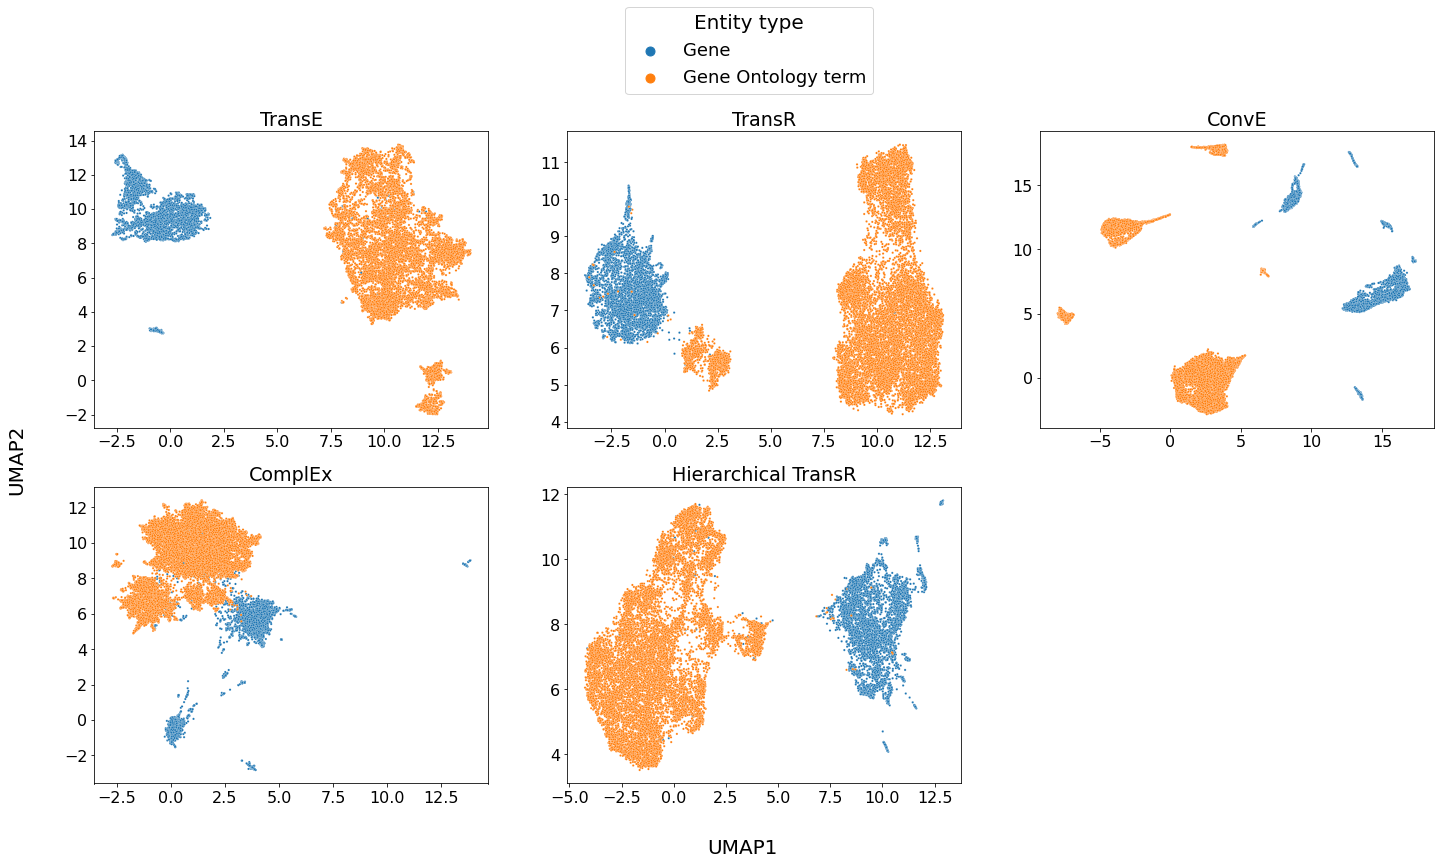

In [8]:
## plot entity embeddings, colouring points by entity type (gene or GO term)

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(2, 3, figsize = (24, 12))

for model, (i, j) in zip(embedding_umaps, product([0, 1], [0, 1, 2])):
    if model == 'Hierarchical TransR': 
        entity_types = custom_entity_types
    else:
        entity_types = pykeen_entity_types
    
    umap_representation = embedding_umaps[model]
    sns.scatterplot(x = umap_representation[:,0], 
                    y = umap_representation[:,1],
                    hue = entity_types, 
                    s = 5,
                    ax = axs[i, j])
    axs[i, j].set_title(model)
    if i == 1 and j == 1:
        axs[i, j].legend(fontsize = 18, title = 'Entity type', markerscale = 1.5, 
                         bbox_to_anchor = [0.80, 2.65], title_fontsize = 20)
    else:
        axs[i, j].get_legend().remove()
        
axs[1, 2].axis('off')
fig.text(0.08, 0.5, 'UMAP2', ha = 'center', va = 'center', rotation = 'vertical', fontsize = 20)
fig.text(0.5, 0.05, 'UMAP1', ha = 'center', va = 'center', rotation = 'horizontal', fontsize = 20)

plt.savefig('../figures/fig4a.png', facecolor = 'white', bbox_inches = 'tight', dpi = 300)

Next we'll focus solely on gene embeddings, extracting genes from the full set of embeddings and the genes' ensembl IDs.

In [9]:
# get genes with trained embeddings
custom_embedded_genes = pd.Series([ent for ent, ent_type in zip(custom_embedded_entities, custom_entity_types)
                                   if ent_type == 'Gene'])
custom_embedded_gene_ensembls = pd.Series([custom_model['entities'][custom_entity_idx2id[ent]]['properties']['ensembl'] 
                                           for ent in custom_embedded_genes])
pykeen_embedded_genes = pd.Series([ent for ent, ent_type in zip(pykeen_embedded_entities, pykeen_entity_types)
                                   if ent_type == 'Gene'])
pykeen_embedded_gene_ensembls = pd.Series([custom_model['entities'][pykeen_entity_idx2id[ent]]['properties']['ensembl'] 
                                           for ent in pykeen_embedded_genes])

We'll be colouring points in the plot by membership in the "Cell Cycle Checkpoints" pathway from Reactome. We'll import the xml file containing a list of genes involved in that pathway and identify genes in the PyKeen/Hierarchical TransR models that are in the pathway's gene set.

In [10]:
# import file of cell cycle checkpoint genes, taken from mSigDB 

import xml.etree.ElementTree as ET

tree = ET.parse('data/genesets/Cell_cycle_checkpoint_genes.xml')
root = tree.getroot()
CCC_genes = root.find('GENESET').get('MEMBERS').split(',')

custom_genes_in_CCC = np.where(custom_embedded_gene_ensembls.isin(CCC_genes),
                               'Yes', 'No')
pykeen_genes_in_CCC = np.where(pykeen_embedded_gene_ensembls.isin(CCC_genes),
                               'Yes', 'No')

In [11]:
# extract gene embeddings
pykeen_gene_tensor = torch.tensor(pykeen_embedded_genes, dtype = torch.long)

all_gene_embeddings = OrderedDict({'TransE': transE_embeddings(pykeen_gene_tensor).detach().numpy(), 
                                   'TransR': transR_embeddings(pykeen_gene_tensor).detach().numpy(),
                                   'ConvE': convE_embeddings(pykeen_gene_tensor).detach().numpy(), 
                                   'ComplEx': complEx_embeddings(pykeen_gene_tensor).detach().numpy(),
                                   'Hierarchical TransR': tf.gather(custom_embeddings, custom_embedded_genes).numpy()})

Now we'll run a UMAP on the gene embeddings specifically.

In [12]:
# run umaps for gene embeddings

gene_embedding_umaps = OrderedDict({model: UMAP(random_state = 123).fit_transform(all_gene_embeddings[model])
                                    for model in all_gene_embeddings})

And finally plot the 2D projection of gene embeddings, colouring points by whether they belong to the "Cell Cycle Checkpoints" pathway.

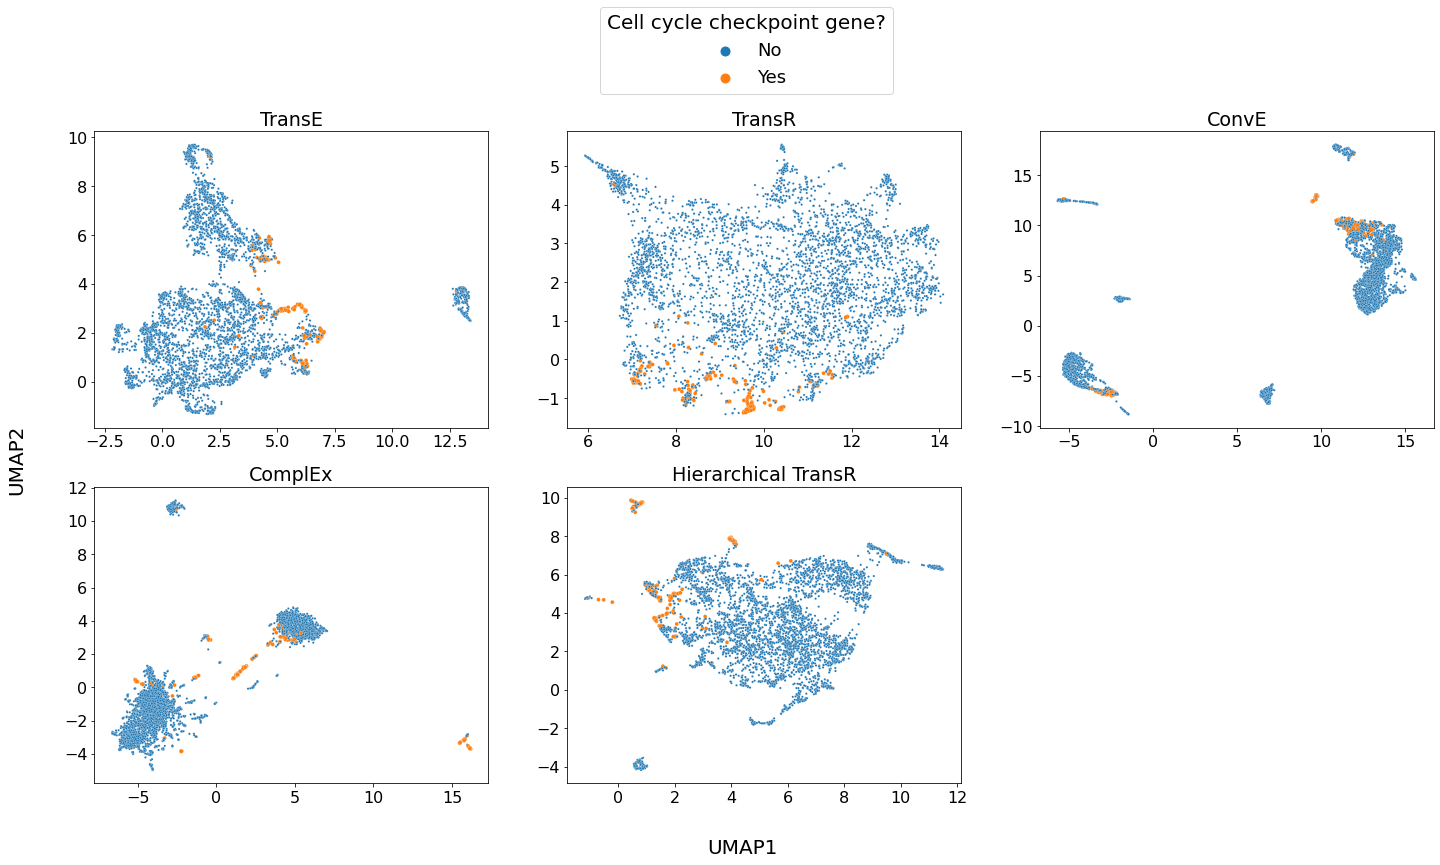

In [13]:
## plot gene embeddings, colouring genes by membership in "Cell Cycle Checkpoints" pathway

plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(2, 3, figsize = (24, 12))

for model, (i, j) in zip(gene_embedding_umaps, product([0, 1], [0, 1, 2])):
    if model == 'Hierarchical TransR':
        in_CCC = custom_genes_in_CCC
    else:
        in_CCC = pykeen_genes_in_CCC
    
    umap_representation = gene_embedding_umaps[model]
    sns.scatterplot(x = umap_representation[:,0], 
                    y = umap_representation[:,1],
                    hue = in_CCC, 
                    s = np.where(in_CCC == 'Yes', 15, 5),
                    ax = axs[i, j],
                    palette = {'Yes': 'C1', 'No': 'C0'})
    axs[i, j].set_title(model)
    if i == 1 and j == 1:
        axs[i, j].legend(fontsize = 18, title = 'Cell cycle checkpoint gene?', markerscale = 1.5, 
                         bbox_to_anchor = [0.85, 2.65], title_fontsize = 20)
    else:
        axs[i, j].get_legend().remove()
        
axs[1, 2].axis('off')
fig.text(0.08, 0.5, 'UMAP2', ha = 'center', va = 'center', rotation = 'vertical', fontsize = 20)
fig.text(0.5, 0.05, 'UMAP1', ha = 'center', va = 'center', rotation = 'horizontal', fontsize = 20)

plt.savefig('../figures/fig4b.png', facecolor = 'white', bbox_inches = 'tight', dpi = 300)